In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re

import pandas as pd
import numpy as np

import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
pd.options.plotting.backend = "plotly"
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
path = '/content/drive/MyDrive/Univerui/KTND/FinancialPhraseBank-v1.0/Sentences_75Agree.txt'
tf.random.set_seed(42)

In [4]:
def get_lines(filename):
  with open(filename, 'r', encoding="utf_16_be") as f:
    return f.readlines()

def preprocess_text(filename):
  input_file = get_lines(filename)
  data = []
  for line in input_file:
    data_split = line.strip().split('.@')
    if len(data_split) == 2:
      line_data = {
          'Sentence': data_split[0].lower(),
          'Sentiment': data_split[1]
      }
    data.append(line_data)

  return data


In [5]:
input_file = preprocess_text(path)
dataset = pd.DataFrame(input_file)
dataset.head()

,Sentence,Sentiment
0,"according to gran , the company has no plans t...",neutral
1,with the new production plant the company woul...,positive
2,"for the last quarter of 2010 , componenta 's n...",positive
3,"in the third quarter of 2010 , net sales incre...",positive
4,operating profit rose to eur 13.1 mn from eur ...,positive


In [ ]:
dataset['Sentiment'].value_counts()

neutral     2146
positive     891
negative     416
Name: Sentiment, dtype: int64

# Exploring data

https://huggingface.co/sentence-transformers/LaBSE

In [ ]:
random_10_sentences = dataset.sample(n=10)

for _, s in random_10_sentences.iterrows():
  print('-'*20)
  print(f"Sentiment: {s['Sentiment']}")
  print(f"Sentence:\n{s['Sentence']}")
  print('-'*20)
  print('\n\n')

--------------------
Sentiment: neutral
Sentence:
the annual report will be sent automatically to shareholders holding at least 2,000 sampo plc shares 
--------------------



--------------------
Sentiment: neutral
Sentence:
as an alternative to the share exchange , panostaja offers a full cash consideration at the value of 1.27 euro $ 1.7 per share 
--------------------



--------------------
Sentiment: neutral
Sentence:
finnish talvivaara mining co hel : tlv1v said thursday it had picked bofa merrill lynch and jpmorgan nyse : jpm as joint bookrunners of its planned issue of convertible notes worth up to eur250m usd332m 
--------------------



--------------------
Sentiment: neutral
Sentence:
rautalinko was resposnible also for mobility services , and his job in this division will be continued by marek hintze 
--------------------



--------------------
Sentiment: negative
Sentence:
the dismissed staff members will now take the matter to court unless it can be settled outside 
---

In [ ]:
dataset.groupby('Sentiment').count().plot(kind='bar')

In [ ]:
dataset['length'] = dataset.Sentence.str.split().apply(len)

dataset.length.describe()

count    3453.000000
mean       21.713003
std         9.964168
min         3.000000
25%        14.000000
50%        20.000000
75%        28.000000
max        80.000000
Name: length, dtype: float64

In [ ]:
dataset.length.plot(kind='hist')

In [ ]:
np.percentile(dataset.length, 95)

41.0

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def wordcloud_gen(df, sentiment):
  combine_sentences = " ".join([sentence for sentence in df[df.Sentiment == sentiment]['Sentence']])

  wc = WordCloud(background_color='white', max_words=41, stopwords=STOPWORDS)
  plt.figure(figsize=(10,10))
  plt.imshow(wc.generate(combine_sentences))
  plt.title(f'{sentiment} words')
  plt.axis('off')
  plt.show()

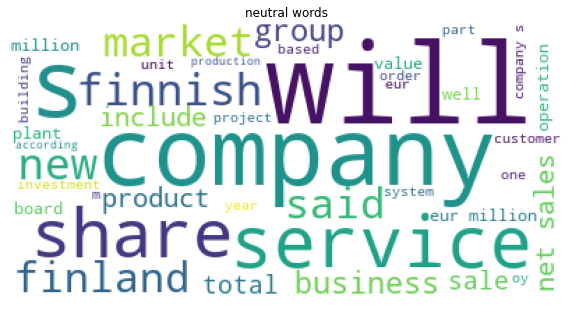

In [ ]:
wordcloud_gen(dataset, 'neutral')

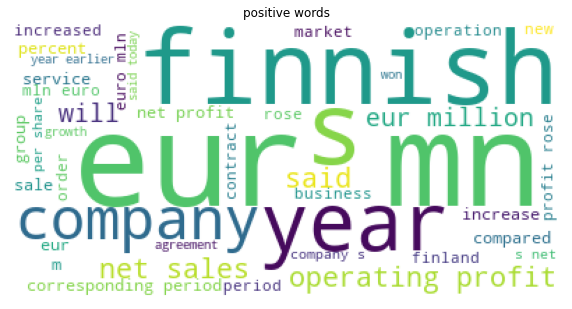

In [ ]:
wordcloud_gen(dataset, 'positive')

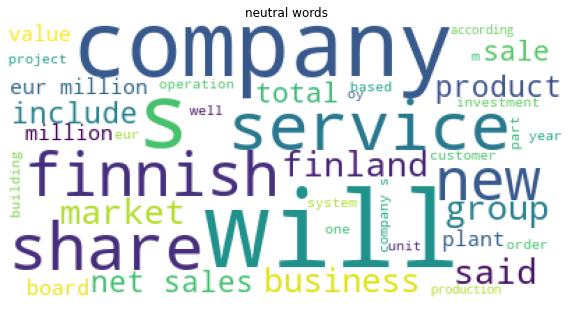

In [ ]:
wordcloud_gen(dataset, 'neutral')

# Text preprocessing

In [6]:
def preprocessing_sentences(sentence):
  # Removing non letters
  sentence = re.sub(r'[^a-zA-Z0-9]', ' ', sentence)

  # Creating word tokens
  words = sentence.split()

  # Removing stopwords
  words = [word for word in words if word not in stopwords.words('english')]

  # Stemming
  words = [PorterStemmer().stem(word) for word in words]

  return " ".join(words)


In [7]:
dataset['clean_sentences'] = dataset['Sentence'].apply(preprocessing_sentences)

In [8]:
random_3_sentences = dataset.sample(n=3)

for _, s in random_3_sentences.iterrows():
  print('-'*20)
  print(f"Sentiment: {s['Sentiment']}\n")
  print(f"Sentence:\n{s['Sentence']}\n")
  print(f'Clean sentence:\n{s["clean_sentences"]}')
  print('-'*20)
  print('\n')

--------------------
Sentiment: neutral

Sentence:
the store is located in poznan in a shopping center named pestka , the company added 

Clean sentence:
store locat poznan shop center name pestka compani ad
--------------------


--------------------
Sentiment: negative

Sentence:
changes in the market situation and tougher price competition have substantially reduced demand for bread packaging manufactured at the kauhava plant , according to the company 

Clean sentence:
chang market situat tougher price competit substanti reduc demand bread packag manufactur kauhava plant accord compani
--------------------


--------------------
Sentiment: neutral

Sentence:
compagnie de financement foncier - is to issue a benchmark , 10 year covered deal in euros 

Clean sentence:
compagni de financ foncier issu benchmark 10 year cover deal euro
--------------------




In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dataset['class'] = le.fit_transform(dataset['Sentiment'])

dataset['clean_length'] = dataset.clean_sentences.str.split().apply(len)

dataset.head()

,Sentence,Sentiment,clean_sentences,class,clean_length
0,"according to gran , the company has no plans t...",neutral,accord gran compani plan move product russia a...,1,10
1,with the new production plant the company woul...,positive,new product plant compani would increas capac ...,2,20
2,"for the last quarter of 2010 , componenta 's n...",positive,last quarter 2010 componenta net sale doubl eu...,2,21
3,"in the third quarter of 2010 , net sales incre...",positive,third quarter 2010 net sale increas 5 2 eur 20...,2,20
4,operating profit rose to eur 13.1 mn from eur ...,positive,oper profit rose eur 13 1 mn eur 8 7 mn corres...,2,19


In [9]:
unique = set()
for sentence in list(dataset['clean_sentences']):
  unique.update(sentence.split())

print(f'Dataset contains {len(unique)} words')
print(f'Most of sentences are {np.percentile(dataset.clean_length, 95)} word long')

Dataset contains 6153 words
Most of sentences are 27.0 word long


In [10]:
X = dataset['clean_sentences']
y = dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2935,), (2935,), (518,), (518,))

In [12]:
max_tokens = 6153

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=27)

In [13]:
text_vectorizer.adapt(X_train)

In [14]:
text_vocab = text_vectorizer.get_vocabulary()
print(f'Vocabulary consists of {len(text_vocab)} words')

Vocabulary consists of 5638 words


In [15]:
token_embed = tf.keras.layers.Embedding(input_dim=len(text_vocab),
                                        output_dim=30,
                                        mask_zero=True,
                                        name='token_embedding_layer')

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Helper functions

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Modeling Experimentations

## Scikit-Learn classifiers

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

### Model_0: MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X_train, y_train)

y_pred_0 = model_0.predict(X_test)
model_0_results = calculate_results(y_test, y_pred_0)
model_0_results

{'accuracy': 74.7104247104247,
 'precision': 0.7635623689677743,
 'recall': 0.747104247104247,
 'f1': 0.6969720323849953}

### Model_1: KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_1 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', KNeighborsClassifier())
])

model_1.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)
model_1_results = calculate_results(y_test, y_pred_1)
model_1_results

{'accuracy': 73.55212355212355,
 'precision': 0.7362741759536908,
 'recall': 0.7355212355212355,
 'f1': 0.7108883656086529}

### Model_2: SVC

In [ ]:
from sklearn.svm import SVC

model_2 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', SVC())
])

model_2.fit(X_train, y_train)

y_pred_2 = model_2.predict(X_test)
model_2_results = calculate_results(y_test, y_pred_2)
model_2_results

{'accuracy': 81.46718146718148,
 'precision': 0.8154084421301527,
 'recall': 0.8146718146718147,
 'f1': 0.7997443539323214}

### Model_3: Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_3 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
])

model_3.fit(X_train, y_train)

y_pred_3 = model_3.predict(X_test)
model_3_results = calculate_results(y_test, y_pred_3)
model_3_results

{'accuracy': 78.95752895752895,
 'precision': 0.7928024409785365,
 'recall': 0.7895752895752896,
 'f1': 0.7908784757620976}

### Model_4: Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_4 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

model_4.fit(X_train, y_train)

y_pred_4 = model_4.predict(X_test)
model_4_results = calculate_results(y_test, y_pred_4)
model_4_results

{'accuracy': 84.74903474903475,
 'precision': 0.8489269837997351,
 'recall': 0.8474903474903475,
 'f1': 0.838440014457076}

### Model_5: AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model_5 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', AdaBoostClassifier())
])

model_5.fit(X_train, y_train)

y_pred_5 = model_5.predict(X_test)
model_5_results = calculate_results(y_test, y_pred_5)
model_5_results

{'accuracy': 79.34362934362935,
 'precision': 0.7864588602293521,
 'recall': 0.7934362934362934,
 'f1': 0.7869590439027351}

### Model_6: MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

model_6 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', MLPClassifier())
])

model_6.fit(X_train, y_train)

y_pred_6 = model_6.predict(X_test)
model_6_results = calculate_results(y_test, y_pred_6)
model_6_results

{'accuracy': 78.95752895752895,
 'precision': 0.7882112928778918,
 'recall': 0.7895752895752896,
 'f1': 0.7872826657081645}

### Results

In [ ]:
sl = {
    'MultinomialNB': model_0_results,
    'KNN': model_1_results,
    'SVC': model_2_results,
    'DecisionTreeClassifier': model_3_results,
    'RandomForestClassifier': model_4_results,
    'AdaBoostClassifier': model_5_results,
    'MLPClassifier': model_6_results,
}

sl_results = pd.DataFrame(sl)
sl_results.head()

,MultinomialNB,KNN,SVC,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,MLPClassifier
accuracy,74.710425,73.552124,81.467181,78.957529,84.749035,79.343629,78.957529
precision,0.763562,0.736274,0.815408,0.792802,0.848927,0.786459,0.788211
recall,0.747104,0.735521,0.814672,0.789575,0.847490,0.793436,0.789575
f1,0.696972,0.710888,0.799744,0.790878,0.838440,0.786959,0.787283


## CNN classifiers

### Model_7: Single Conv1D + MaxPool + single FC

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(token_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_7 = tf.keras.Model(inputs, outputs)

model_7.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_7_history = model_7.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

Epoch 1/5
92/92 [==============================] - 2s 10ms/step - loss: 1.0399 - accuracy: 0.5182 - val_loss: 0.9356 - val_accuracy: 0.7722
Epoch 2/5
92/92 [==============================] - 1s 7ms/step - loss: 0.7735 - accuracy: 0.9404 - val_loss: 0.7720 - val_accuracy: 0.8147
Epoch 3/5
92/92 [==============================] - 1s 8ms/step - loss: 0.5953 - accuracy: 0.9278 - val_loss: 0.6617 - val_accuracy: 0.8205
Epoch 4/5
92/92 [==============================] - 1s 9ms/step - loss: 0.4601 - accuracy: 0.9267 - val_loss: 0.5862 - val_accuracy: 0.8224
Epoch 5/5
92/92 [==============================] - 1s 9ms/step - loss: 0.3592 - accuracy: 0.9383 - val_loss: 0.5386 - val_accuracy: 0.8243


In [ ]:
y_pred_7 = tf.argmax(model_7.predict(test_dataset),axis=1)
model_7_results = calculate_results(y_test, y_pred_7)
model_7_results

17/17 [==============================] - 0s 2ms/step


{'accuracy': 82.43243243243244,
 'precision': 0.8224312001566343,
 'recall': 0.8243243243243243,
 'f1': 0.8146766205749018}

### Model_8: Same as model_7 but no FC layer

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(token_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_8 = tf.keras.Model(inputs, outputs)

model_8.compile(loss='sparse_categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

model_8_history = model_8.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_8 = tf.argmax(model_8.predict(test_dataset),axis=1)
model_8_results = calculate_results(y_test, y_pred_8)
model_8_results

Epoch 1/5
184/184 [==============================] - 4s 17ms/step - loss: 0.4736 - accuracy: 0.8239 - val_loss: 0.4378 - val_accuracy: 0.8456
Epoch 2/5
184/184 [==============================] - 4s 19ms/step - loss: 0.1395 - accuracy: 0.9598 - val_loss: 0.4769 - val_accuracy: 0.8552
Epoch 3/5
184/184 [==============================] - 3s 18ms/step - loss: 0.0567 - accuracy: 0.9877 - val_loss: 0.5385 - val_accuracy: 0.8494
Epoch 4/5
184/184 [==============================] - 3s 15ms/step - loss: 0.0276 - accuracy: 0.9949 - val_loss: 0.5942 - val_accuracy: 0.8456
Epoch 5/5
33/33 [==============================] - 0s 4ms/step


{'accuracy': 84.16988416988417,
 'precision': 0.8416884511464031,
 'recall': 0.8416988416988417,
 'f1': 0.8393313610839459}

### Model_9: Same as model_7 but average pooling

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_9 = tf.keras.Model(inputs, outputs)

model_9.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_9_history = model_9.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_9 = tf.argmax(model_9.predict(test_dataset),axis=1)
model_9_results = calculate_results(y_test, y_pred_9)
model_9_results

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 1.0202 - accuracy: 0.5738 - val_loss: 0.9697 - val_accuracy: 0.6178
Epoch 2/5
92/92 [==============================] - 1s 9ms/step - loss: 0.8892 - accuracy: 0.6228 - val_loss: 0.8842 - val_accuracy: 0.6178
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.7827 - accuracy: 0.6399 - val_loss: 0.8075 - val_accuracy: 0.6332
Epoch 4/5
92/92 [==============================] - 1s 7ms/step - loss: 0.6883 - accuracy: 0.6756 - val_loss: 0.7431 - val_accuracy: 0.6795
Epoch 5/5
17/17 [==============================] - 0s 3ms/step


{'accuracy': 71.62162162162163,
 'precision': 0.7502757859900717,
 'recall': 0.7162162162162162,
 'f1': 0.6533603028930132}

### Model_10: Same as model_7 but two conv1d layers

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(token_embeddings)
x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_10 = tf.keras.Model(inputs, outputs)

model_10.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_10_history = model_10.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_10 = tf.argmax(model_10.predict(test_dataset),axis=1)
model_10_results = calculate_results(y_test, y_pred_10)
model_10_results

Epoch 1/5
92/92 [==============================] - 4s 29ms/step - loss: 0.7968 - accuracy: 0.6269 - val_loss: 0.7509 - val_accuracy: 0.6409
Epoch 2/5
92/92 [==============================] - 1s 11ms/step - loss: 0.5802 - accuracy: 0.6988 - val_loss: 0.6347 - val_accuracy: 0.7413
Epoch 3/5
92/92 [==============================] - 1s 9ms/step - loss: 0.4035 - accuracy: 0.8848 - val_loss: 0.5588 - val_accuracy: 0.8108
Epoch 4/5
92/92 [==============================] - 1s 9ms/step - loss: 0.2797 - accuracy: 0.9683 - val_loss: 0.5094 - val_accuracy: 0.8205
Epoch 5/5
17/17 [==============================] - 0s 3ms/step


{'accuracy': 81.46718146718148,
 'precision': 0.8093082399534012,
 'recall': 0.8146718146718147,
 'f1': 0.810589859341338}

### Model_11: Same as model_7 but introducing dropout layer after embeddings

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Dropout(.2)(token_embeddings)
x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_11 = tf.keras.Model(inputs, outputs)

model_11.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_11_history = model_11.fit(train_dataset,
                              epochs=10,
                              validation_data=test_dataset)

y_pred_11 = tf.argmax(model_11.predict(test_dataset),axis=1)
model_11_results = calculate_results(y_test, y_pred_11)
model_11_results

Epoch 1/10
92/92 [==============================] - 3s 10ms/step - loss: 0.8592 - accuracy: 0.6671 - val_loss: 0.8099 - val_accuracy: 0.7394
Epoch 2/10
92/92 [==============================] - 1s 8ms/step - loss: 0.6827 - accuracy: 0.7400 - val_loss: 0.6883 - val_accuracy: 0.7838
Epoch 3/10
92/92 [==============================] - 1s 10ms/step - loss: 0.5451 - accuracy: 0.8239 - val_loss: 0.6026 - val_accuracy: 0.8127
Epoch 4/10
92/92 [==============================] - 1s 10ms/step - loss: 0.4324 - accuracy: 0.8835 - val_loss: 0.5397 - val_accuracy: 0.8108
Epoch 5/10
92/92 [==============================] - 1s 10ms/step - loss: 0.3396 - accuracy: 0.9267 - val_loss: 0.4983 - val_accuracy: 0.8224
Epoch 6/10
92/92 [==============================] - 1s 9ms/step - loss: 0.2646 - accuracy: 0.9567 - val_loss: 0.4721 - val_accuracy: 0.8340
Epoch 7/10
92/92 [==============================] - 1s 10ms/step - loss: 0.2071 - accuracy: 0.9744 - val_loss: 0.4562 - val_accuracy: 0.8282
Epoch 8/10
92/9

{'accuracy': 82.81853281853282,
 'precision': 0.8287273669744679,
 'recall': 0.8281853281853282,
 'f1': 0.8279034498845851}

### Model_12: same as model_11 but increasing filters

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Dropout(.2)(token_embeddings)
x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_12 = tf.keras.Model(inputs, outputs)

model_12.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_12_history = model_12.fit(train_dataset,
                              epochs=10,
                              validation_data=test_dataset)

y_pred_12 = tf.argmax(model_12.predict(test_dataset),axis=1)
model_12_results = calculate_results(y_test, y_pred_12)
model_12_results

Epoch 1/10
92/92 [==============================] - 3s 17ms/step - loss: 0.8666 - accuracy: 0.5986 - val_loss: 0.7565 - val_accuracy: 0.6950
Epoch 2/10
92/92 [==============================] - 1s 9ms/step - loss: 0.5652 - accuracy: 0.7755 - val_loss: 0.5990 - val_accuracy: 0.7722
Epoch 3/10
92/92 [==============================] - 1s 9ms/step - loss: 0.4094 - accuracy: 0.8600 - val_loss: 0.5272 - val_accuracy: 0.7915
Epoch 4/10
92/92 [==============================] - 1s 10ms/step - loss: 0.3100 - accuracy: 0.9019 - val_loss: 0.4896 - val_accuracy: 0.8185
Epoch 5/10
92/92 [==============================] - 1s 11ms/step - loss: 0.2466 - accuracy: 0.9319 - val_loss: 0.4713 - val_accuracy: 0.8282
Epoch 6/10
92/92 [==============================] - 1s 11ms/step - loss: 0.2011 - accuracy: 0.9557 - val_loss: 0.4624 - val_accuracy: 0.8282
Epoch 7/10
92/92 [==============================] - 1s 11ms/step - loss: 0.1672 - accuracy: 0.9700 - val_loss: 0.4582 - val_accuracy: 0.8398
Epoch 8/10
92/9

{'accuracy': 84.16988416988417,
 'precision': 0.84054770224983,
 'recall': 0.8416988416988417,
 'f1': 0.8410248893597083}

### Model_13: as same model_12 but increasing kernel_size

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Dropout(.2)(token_embeddings)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_13 = tf.keras.Model(inputs, outputs)

model_13.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_13_history = model_13.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_13 = tf.argmax(model_13.predict(test_dataset),axis=1)
model_13_results = calculate_results(y_test, y_pred_13)
model_13_results

Epoch 1/5
92/92 [==============================] - 3s 14ms/step - loss: 0.7323 - accuracy: 0.6375 - val_loss: 0.6726 - val_accuracy: 0.7239
Epoch 2/5
92/92 [==============================] - 1s 10ms/step - loss: 0.4191 - accuracy: 0.8797 - val_loss: 0.5277 - val_accuracy: 0.8224
Epoch 3/5
92/92 [==============================] - 1s 10ms/step - loss: 0.2497 - accuracy: 0.9816 - val_loss: 0.4705 - val_accuracy: 0.8243
Epoch 4/5
92/92 [==============================] - 1s 9ms/step - loss: 0.1627 - accuracy: 0.9949 - val_loss: 0.4502 - val_accuracy: 0.8243
Epoch 5/5
17/17 [==============================] - 0s 3ms/step


{'accuracy': 82.23938223938224,
 'precision': 0.8211506289261098,
 'recall': 0.8223938223938224,
 'f1': 0.8207928640863887}

### Model_14

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

model_14 = tf.keras.Model(inputs, outputs)

model_14.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_14_history = model_14.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_14 = tf.argmax(model_14.predict(test_dataset),axis=1)
model_14_results = calculate_results(y_test, y_pred_14)
model_14_results

Epoch 1/5
92/92 [==============================] - 2s 12ms/step - loss: 0.8888 - accuracy: 0.6985 - val_loss: 0.7939 - val_accuracy: 0.6950
Epoch 2/5
92/92 [==============================] - 1s 9ms/step - loss: 0.7019 - accuracy: 0.7220 - val_loss: 0.7005 - val_accuracy: 0.7162
Epoch 3/5
92/92 [==============================] - 1s 9ms/step - loss: 0.5877 - accuracy: 0.7748 - val_loss: 0.6353 - val_accuracy: 0.7490
Epoch 4/5
92/92 [==============================] - 1s 7ms/step - loss: 0.4927 - accuracy: 0.8235 - val_loss: 0.5868 - val_accuracy: 0.7780
Epoch 5/5
17/17 [==============================] - 0s 3ms/step


{'accuracy': 78.76447876447877,
 'precision': 0.8032507613851719,
 'recall': 0.7876447876447876,
 'f1': 0.7470583401140108}

### Model_15

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(256, kernel_size=3, activation="relu")(token_embeddings)
x = tf.keras.layers.Conv1D(256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)

x = tf.keras.layers.Conv1D(256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Conv1D(256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(3)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_15 = tf.keras.Model(inputs, outputs)

model_15.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_15_history = model_15.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_15 = tf.argmax(model_15.predict(test_dataset),axis=1)
model_15_results = calculate_results(y_test, y_pred_15)
model_15_results

Epoch 1/5
92/92 [==============================] - 10s 100ms/step - loss: 0.5163 - accuracy: 0.7819 - val_loss: 0.6075 - val_accuracy: 0.8127
Epoch 2/5
92/92 [==============================] - 9s 96ms/step - loss: 0.0816 - accuracy: 0.9779 - val_loss: 0.7971 - val_accuracy: 0.8205
Epoch 3/5
92/92 [==============================] - 9s 96ms/step - loss: 0.0465 - accuracy: 0.9850 - val_loss: 0.9208 - val_accuracy: 0.8166
Epoch 4/5
92/92 [==============================] - 9s 96ms/step - loss: 0.0291 - accuracy: 0.9918 - val_loss: 1.0096 - val_accuracy: 0.8166
Epoch 5/5
17/17 [==============================] - 0s 14ms/step


{'accuracy': 81.08108108108108,
 'precision': 0.8223991597071376,
 'recall': 0.8108108108108109,
 'f1': 0.8099496894657339}

### Model_16: Conv1D and LSTM mix

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation="relu")(token_embeddings)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dropout(.4)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_16 = tf.keras.Model(inputs, outputs)

model_16.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_16_history = model_16.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_16 = tf.argmax(model_16.predict(test_dataset),axis=1)
model_16_results = calculate_results(y_test, y_pred_16)
model_16_results

Epoch 1/5
92/92 [==============================] - 11s 31ms/step - loss: 0.9114 - accuracy: 0.6467 - val_loss: 0.7940 - val_accuracy: 0.6506
Epoch 2/5
92/92 [==============================] - 2s 18ms/step - loss: 0.6275 - accuracy: 0.7560 - val_loss: 0.6089 - val_accuracy: 0.7722
Epoch 3/5
92/92 [==============================] - 2s 18ms/step - loss: 0.3816 - accuracy: 0.8688 - val_loss: 0.5013 - val_accuracy: 0.8224
Epoch 4/5
92/92 [==============================] - 2s 21ms/step - loss: 0.2222 - accuracy: 0.9458 - val_loss: 0.4846 - val_accuracy: 0.8398
Epoch 5/5
17/17 [==============================] - 1s 6ms/step


{'accuracy': 84.36293436293437,
 'precision': 0.8453262749092805,
 'recall': 0.8436293436293436,
 'f1': 0.8421507979773895}

### Model_17: same as model 16 but SGD instead of adam

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation="relu")(token_embeddings)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dropout(.4)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_17 = tf.keras.Model(inputs, outputs)

epochs=5
lr = 0.001
decay_rate = lr / epochs

model_17.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
                metrics=['accuracy'])

model_17_history = model_17.fit(train_dataset,
                              epochs=epochs,
                              validation_data=test_dataset)

y_pred_17 = tf.argmax(model_17.predict(test_dataset),axis=1)
model_17_results = calculate_results(y_test, y_pred_17)
model_17_results

Epoch 1/5
92/92 [==============================] - 7s 30ms/step - loss: 1.1201 - accuracy: 0.2767 - val_loss: 1.0570 - val_accuracy: 0.3282
Epoch 2/5
92/92 [==============================] - 2s 16ms/step - loss: 1.0351 - accuracy: 0.4893 - val_loss: 0.9906 - val_accuracy: 0.6293
Epoch 3/5
92/92 [==============================] - 2s 18ms/step - loss: 0.9774 - accuracy: 0.6160 - val_loss: 0.9447 - val_accuracy: 0.6197
Epoch 4/5
92/92 [==============================] - 1s 16ms/step - loss: 0.9361 - accuracy: 0.6290 - val_loss: 0.9124 - val_accuracy: 0.6178
Epoch 5/5
17/17 [==============================] - 1s 6ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 61.77606177606177,
 'precision': 0.3816281808559801,
 'recall': 0.6177606177606177,
 'f1': 0.4717980851632403}

### Model_24: Word2vec + CNN

In [ ]:
sen = []
for sentence in X_train.to_list():
  sen.append(sentence.split())

sen[0]

['cooper', 'doubl', 'switch', 'convert', 'capac']

In [ ]:
from gensim.models.word2vec import Word2Vec
word2vec_model = Word2Vec(sen, size=500, window=3, min_count=1, workers=9)
print(word2vec_model)

Word2Vec(vocab=5636, size=500, alpha=0.025)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token = Tokenizer(5636)
token.fit_on_texts(X)
text = token.texts_to_sequences(X)

text = pad_sequences(text, 50)

x_tr, x_te, y_tr, y_t = train_test_split(np.array(text), y, test_size=0.2)

In [ ]:
model_24 = tf.keras.Sequential([
    word2vec_model.wv.get_keras_embedding(True),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv1D(50,3,activation='relu', padding='same'),
    tf.keras.layers.Conv1D(50,3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Conv1D(100,3,activation='relu', padding='same'),
    tf.keras.layers.Conv1D(100,3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv1D(200,3,activation='relu', padding='same'),
    tf.keras.layers.Conv1D(200,3, activation='relu', padding='same'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(3, activation='softmax'),
])


In [ ]:
model_24.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_24_history = model_24.fit(x_tr, y_tr,
                              epochs=3,
                              batch_size=16,
                              validation_data=(x_te, y_t))

In [ ]:
y_pred_24 = tf.argmax(model_24.predict(x_te),axis=1)

22/22 [==============================] - 1s 30ms/step


In [ ]:
model_24_results = calculate_results(y_t, y_pred_24)
model_24_results

{'accuracy': 77.85817655571635,
 'precision': 0.7596855230491524,
 'recall': 0.7785817655571635,
 'f1': 0.7559141201031575}

### Model 31: Best DNN model_16 with regularizations

#### Regularization on Conv1D Layer [UPDATE: No improvements with l1, l2, l1_2]

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3,
                           padding='same', activation="relu",
                           kernel_regularizer='l1_l2')(token_embeddings)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dropout(.4)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_31 = tf.keras.Model(inputs, outputs)

model_31.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_31_history = model_31.fit(train_dataset,
                              epochs=20,
                              validation_data=test_dataset,
                              verbose=0)

y_pred_31 = tf.argmax(model_31.predict(test_dataset),axis=1)
model_31_results = calculate_results(y_test, y_pred_31)
model_31_results

17/17 [==============================] - 1s 5ms/step


{'accuracy': 77.99227799227799,
 'precision': 0.7773966617133992,
 'recall': 0.7799227799227799,
 'f1': 0.7773988612782847}

#### Regularization on LSTM [UPDATE: No improvements with l1, l2, l1_2]

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3,
                           padding='same', activation="relu")(token_embeddings)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                           kernel_regularizer='l2'))(x)
x = tf.keras.layers.Dropout(.4)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_32 = tf.keras.Model(inputs, outputs)

model_32.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])

model_32_history = model_32.fit(train_dataset,
                              epochs=20,
                              validation_data=test_dataset,
                              verbose=0)

y_pred_32 = tf.argmax(model_32.predict(test_dataset),axis=1)
model_32_results = calculate_results(y_test, y_pred_32)
model_32_results

17/17 [==============================] - 1s 6ms/step


{'accuracy': 75.0965250965251,
 'precision': 0.7585622493541057,
 'recall': 0.750965250965251,
 'f1': 0.7532232375137855}

### Best DNN model_16 modifications

- Additional layers -> performence worse
- LSTM inner dropouts -> worse

In [ ]:


inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation="tanh")(token_embeddings)
x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation="tanh")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dropout(.4)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_33 = tf.keras.Model(inputs, outputs)

model_33.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0006),
                metrics=['accuracy'])

model_33_history = model_33.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_33 = tf.argmax(model_33.predict(test_dataset),axis=1)
model_33_results = calculate_results(y_test, y_pred_33)
model_33_results

Epoch 1/5
92/92 [==============================] - 19s 69ms/step - loss: 0.2217 - accuracy: 0.9118 - val_loss: 1.0351 - val_accuracy: 0.7838
Epoch 2/5
92/92 [==============================] - 4s 46ms/step - loss: 0.0183 - accuracy: 0.9952 - val_loss: 1.2075 - val_accuracy: 0.7819
Epoch 3/5
92/92 [==============================] - 5s 60ms/step - loss: 0.0182 - accuracy: 0.9952 - val_loss: 1.1535 - val_accuracy: 0.7915
Epoch 4/5
92/92 [==============================] - 4s 46ms/step - loss: 0.0212 - accuracy: 0.9945 - val_loss: 1.1903 - val_accuracy: 0.7838
Epoch 5/5
17/17 [==============================] - 2s 13ms/step


{'accuracy': 78.18532818532819,
 'precision': 0.7845939455370947,
 'recall': 0.7818532818532818,
 'f1': 0.7829368235118372}

## Pretrained encoder

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)
model_18 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_18.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=["accuracy"])

model_18_history = model_18.fit(train_dataset,
                              epochs=20,
                              validation_data=test_dataset)

y_pred_18 = tf.argmax(model_18.predict(test_dataset),axis=1)
model_18_results = calculate_results(y_test, y_pred_18)
model_18_results

Epoch 1/20
92/92 [==============================] - 4s 24ms/step - loss: 1.0535 - accuracy: 0.5826 - val_loss: 1.0098 - val_accuracy: 0.6197
Epoch 2/20
92/92 [==============================] - 2s 18ms/step - loss: 0.9708 - accuracy: 0.6228 - val_loss: 0.9315 - val_accuracy: 0.6216
Epoch 3/20
92/92 [==============================] - 1s 15ms/step - loss: 0.9033 - accuracy: 0.6303 - val_loss: 0.8733 - val_accuracy: 0.6293
Epoch 4/20
92/92 [==============================] - 2s 17ms/step - loss: 0.8547 - accuracy: 0.6446 - val_loss: 0.8301 - val_accuracy: 0.6390
Epoch 5/20
92/92 [==============================] - 2s 18ms/step - loss: 0.8175 - accuracy: 0.6627 - val_loss: 0.7940 - val_accuracy: 0.6699
Epoch 6/20
92/92 [==============================] - 1s 15ms/step - loss: 0.7864 - accuracy: 0.6821 - val_loss: 0.7628 - val_accuracy: 0.6931
Epoch 7/20
92/92 [==============================] - 2s 18ms/step - loss: 0.7594 - accuracy: 0.6913 - val_loss: 0.7365 - val_accuracy: 0.7027
Epoch 8/20
92

{'accuracy': 76.25482625482626,
 'precision': 0.7425477034523303,
 'recall': 0.7625482625482626,
 'f1': 0.7444059542467647}

### Char encodings

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(sentence) for sentence in X_train.to_list()]
test_chars = [split_chars(sentence) for sentence in X_test.to_list()]

train_chars[0]

'c o o p e r   d o u b l   s w i t c h   c o n v e r t   c a p a c'

In [ ]:
char_lens = [len(sentence) for sentence in X_train.to_list()]
output_sequence_char_len = int(np.percentile(char_lens, 95))
output_sequence_char_len

158

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHARS = len(alphabet)
char_vectorizer = TextVectorization(max_tokens=NUM_CHARS,  
                                    output_sequence_length=output_sequence_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

char_embed = tf.keras.layers.Embedding(input_dim=NUM_CHARS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
X_train.shape[0]/32

91.71875

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")

char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = tf.keras.layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(char_embeddings)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_19 = tf.keras.Model(inputs, outputs)

model_19.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_19_history = model_19.fit(train_char_dataset,
                              epochs=10,
                              validation_data=test_char_dataset)

y_pred_19 = tf.argmax(model_19.predict(test_dataset),axis=1)
model_19_results = calculate_results(y_test, y_pred_19)
model_19_results

Epoch 1/10
92/92 [==============================] - 2s 14ms/step - loss: 0.9188 - accuracy: 0.6221 - val_loss: 0.8727 - val_accuracy: 0.6178
Epoch 2/10
92/92 [==============================] - 1s 11ms/step - loss: 0.8591 - accuracy: 0.6242 - val_loss: 0.8134 - val_accuracy: 0.6313
Epoch 3/10
92/92 [==============================] - 1s 12ms/step - loss: 0.8026 - accuracy: 0.6521 - val_loss: 0.7687 - val_accuracy: 0.6660
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.7678 - accuracy: 0.6756 - val_loss: 0.7464 - val_accuracy: 0.6911
Epoch 5/10
92/92 [==============================] - 1s 13ms/step - loss: 0.7431 - accuracy: 0.6879 - val_loss: 0.7325 - val_accuracy: 0.6834
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.7224 - accuracy: 0.7002 - val_loss: 0.7232 - val_accuracy: 0.6911
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.7032 - accuracy: 0.7083 - val_loss: 0.7128 - val_accuracy: 0.6988
Epoch 8/10
92

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 61.77606177606177,
 'precision': 0.3816281808559801,
 'recall': 0.6177606177606177,
 'f1': 0.4717980851632403}

## LSTM models

### Model_20

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.SpatialDropout1D(.4)(token_embeddings)
x = tf.keras.layers.LSTM(196, dropout=.2, recurrent_dropout=.2)(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_20 = tf.keras.Model(inputs, outputs)

model_20.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_20_history = model_20.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_20 = tf.argmax(model_20.predict(test_dataset),axis=1)
model_20_results = calculate_results(y_test, y_pred_20)
model_20_results

Epoch 1/5
92/92 [==============================] - 20s 163ms/step - loss: 0.1807 - accuracy: 0.9496 - val_loss: 0.7129 - val_accuracy: 0.8069
Epoch 2/5
92/92 [==============================] - 15s 159ms/step - loss: 0.0584 - accuracy: 0.9860 - val_loss: 0.8741 - val_accuracy: 0.7915
Epoch 3/5
92/92 [==============================] - 14s 156ms/step - loss: 0.0479 - accuracy: 0.9860 - val_loss: 0.7722 - val_accuracy: 0.8069
Epoch 4/5
92/92 [==============================] - 14s 152ms/step - loss: 0.0459 - accuracy: 0.9884 - val_loss: 0.8204 - val_accuracy: 0.8069
Epoch 5/5
17/17 [==============================] - 1s 22ms/step


{'accuracy': 80.6949806949807,
 'precision': 0.8147152519837226,
 'recall': 0.806949806949807,
 'f1': 0.8082447058566576}

### Model_21

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(168))(token_embeddings)
x = tf.keras.layers.Dense(10, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_21 = tf.keras.Model(inputs, outputs)

model_21.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_21_history = model_21.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_21 = tf.argmax(model_21.predict(test_dataset),axis=1)
model_21_results = calculate_results(y_test, y_pred_21)
model_21_results

Epoch 1/5
92/92 [==============================] - 76s 166ms/step - loss: 0.1863 - accuracy: 0.9451 - val_loss: 0.6692 - val_accuracy: 0.8050
Epoch 2/5
92/92 [==============================] - 12s 130ms/step - loss: 0.0318 - accuracy: 0.9911 - val_loss: 0.7965 - val_accuracy: 0.8166
Epoch 3/5
92/92 [==============================] - 12s 129ms/step - loss: 0.0195 - accuracy: 0.9932 - val_loss: 0.8466 - val_accuracy: 0.8224
Epoch 4/5
92/92 [==============================] - 15s 159ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.9818 - val_accuracy: 0.8166
Epoch 5/5
17/17 [==============================] - 6s 34ms/step


{'accuracy': 81.27413127413128,
 'precision': 0.8184490120173787,
 'recall': 0.8127413127413128,
 'f1': 0.8127202384858981}

### Model_25: Multiple LSTM layers

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=.2, recurrent_dropout=.2, return_sequences=True))(token_embeddings)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=.1, recurrent_dropout=.3))(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_25 = tf.keras.Model(inputs, outputs)

model_25.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_25_history = model_25.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_25 = tf.argmax(model_25.predict(test_dataset),axis=1)
model_25_results = calculate_results(y_test, y_pred_25)
model_25_results

Epoch 1/5
92/92 [==============================] - 85s 738ms/step - loss: 0.4410 - accuracy: 0.8228 - val_loss: 0.9396 - val_accuracy: 0.7529
Epoch 2/5
92/92 [==============================] - 63s 681ms/step - loss: 0.2908 - accuracy: 0.8661 - val_loss: 0.8205 - val_accuracy: 0.7510
Epoch 3/5
92/92 [==============================] - 63s 686ms/step - loss: 0.1952 - accuracy: 0.9213 - val_loss: 0.9880 - val_accuracy: 0.7490
Epoch 4/5
92/92 [==============================] - 67s 726ms/step - loss: 0.1372 - accuracy: 0.9499 - val_loss: 0.9161 - val_accuracy: 0.7645
Epoch 5/5
17/17 [==============================] - 3s 116ms/step


{'accuracy': 77.41312741312741,
 'precision': 0.7827694229136483,
 'recall': 0.7741312741312741,
 'f1': 0.775028975753409}

### Model_26: Multiple LSTM layers + L1 Regularization

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                                       dropout=.2,
                                                       recurrent_dropout=.2,
                                                       return_sequences=True,
                                                       recurrent_regularizer='l1'))(token_embeddings)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                       dropout=.1,
                                                       recurrent_dropout=.3,
                                                       return_sequences=True,
                                                       recurrent_regularizer='l1'))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,
                                                       dropout=.2,
                                                       recurrent_dropout=.2,
                                                       recurrent_regularizer='l1'))(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_26 = tf.keras.Model(inputs, outputs)

model_26.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_26_history = model_26.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_26 = tf.argmax(model_26.predict(test_dataset),axis=1)
model_26_results = calculate_results(y_test, y_pred_26)
model_26_results

Epoch 1/5
92/92 [==============================] - 46s 264ms/step - loss: 11.7204 - accuracy: 0.8334 - val_loss: 3.9834 - val_accuracy: 0.7452
Epoch 2/5
92/92 [==============================] - 22s 243ms/step - loss: 1.4759 - accuracy: 0.9281 - val_loss: 1.4406 - val_accuracy: 0.7008
Epoch 3/5
92/92 [==============================] - 22s 241ms/step - loss: 0.3110 - accuracy: 0.9574 - val_loss: 1.3012 - val_accuracy: 0.7085
Epoch 4/5
92/92 [==============================] - 22s 241ms/step - loss: 0.1673 - accuracy: 0.9707 - val_loss: 1.2513 - val_accuracy: 0.7548
Epoch 5/5
17/17 [==============================] - 3s 46ms/step


{'accuracy': 75.86872586872587,
 'precision': 0.7776560948997853,
 'recall': 0.7586872586872587,
 'f1': 0.7623707897370077}

### Model_27: same as Model_26 but l2 regulizer

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                                       dropout=.2,
                                                       recurrent_dropout=.2,
                                                       return_sequences=True,
                                                       recurrent_regularizer='l2'))(token_embeddings)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                       dropout=.1,
                                                       recurrent_dropout=.3,
                                                       return_sequences=True,
                                                       recurrent_regularizer='l2'))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,
                                                       dropout=.2,
                                                       recurrent_dropout=.2,
                                                       recurrent_regularizer='l2'))(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_27 = tf.keras.Model(inputs, outputs)

model_27.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_27_history = model_27.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_27 = tf.argmax(model_27.predict(test_dataset),axis=1)
model_27_results = calculate_results(y_test, y_pred_27)
model_27_results

Epoch 1/5
92/92 [==============================] - 46s 278ms/step - loss: 1.4706 - accuracy: 0.8293 - val_loss: 1.1142 - val_accuracy: 0.7568
Epoch 2/5
92/92 [==============================] - 22s 238ms/step - loss: 0.2730 - accuracy: 0.9819 - val_loss: 1.2014 - val_accuracy: 0.7722
Epoch 3/5
92/92 [==============================] - 22s 242ms/step - loss: 0.0924 - accuracy: 0.9894 - val_loss: 1.2104 - val_accuracy: 0.7587
Epoch 4/5
92/92 [==============================] - 22s 236ms/step - loss: 0.0508 - accuracy: 0.9928 - val_loss: 1.2860 - val_accuracy: 0.7529
Epoch 5/5
17/17 [==============================] - 2s 31ms/step


{'accuracy': 75.0965250965251,
 'precision': 0.7703820111455579,
 'recall': 0.750965250965251,
 'f1': 0.7541403117826354}

### Model_28: same as model_26 but l1l2 regulizer

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                                       dropout=.2,
                                                       recurrent_dropout=.2,
                                                       return_sequences=True,
                                                       recurrent_regularizer='l1_l2'))(token_embeddings)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                       dropout=.1,
                                                       recurrent_dropout=.3,
                                                       return_sequences=True,
                                                       recurrent_regularizer='l1_l2'))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,
                                                       dropout=.2,
                                                       recurrent_dropout=.2,
                                                       recurrent_regularizer='l1_l2'))(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_28 = tf.keras.Model(inputs, outputs)

model_28.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_28_history = model_28.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_28 = tf.argmax(model_28.predict(test_dataset),axis=1)
model_28_results = calculate_results(y_test, y_pred_28)
model_28_results

Epoch 1/5
92/92 [==============================] - 63s 269ms/step - loss: 12.8294 - accuracy: 0.8722 - val_loss: 4.5071 - val_accuracy: 0.7239
Epoch 2/5
92/92 [==============================] - 22s 242ms/step - loss: 1.6472 - accuracy: 0.9666 - val_loss: 1.4325 - val_accuracy: 0.7413
Epoch 3/5
92/92 [==============================] - 22s 242ms/step - loss: 0.3094 - accuracy: 0.9809 - val_loss: 1.1662 - val_accuracy: 0.7606
Epoch 4/5
92/92 [==============================] - 23s 248ms/step - loss: 0.1181 - accuracy: 0.9901 - val_loss: 1.1946 - val_accuracy: 0.7703
Epoch 5/5
17/17 [==============================] - 3s 35ms/step


{'accuracy': 77.02702702702703,
 'precision': 0.7767370440799826,
 'recall': 0.7702702702702703,
 'f1': 0.7702305948049158}

### Model_29: Same as Model_25, but with l1 regularization which was best

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=.2, recurrent_dropout=.2, return_sequences=True, recurrent_regularizer='l1'))(token_embeddings)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=.1, recurrent_dropout=.3, recurrent_regularizer='l1'))(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_29 = tf.keras.Model(inputs, outputs)

model_29.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_29_history = model_29.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_29 = tf.argmax(model_29.predict(test_dataset),axis=1)
model_29_results = calculate_results(y_test, y_pred_29)
model_29_results

Epoch 1/5
92/92 [==============================] - 80s 709ms/step - loss: 37.8623 - accuracy: 0.9261 - val_loss: 3.7279 - val_accuracy: 0.7490
Epoch 2/5
92/92 [==============================] - 62s 673ms/step - loss: 1.1695 - accuracy: 0.9918 - val_loss: 2.0803 - val_accuracy: 0.7587
Epoch 3/5
92/92 [==============================] - 66s 717ms/step - loss: 0.7075 - accuracy: 0.9925 - val_loss: 2.1202 - val_accuracy: 0.7625
Epoch 4/5
92/92 [==============================] - 64s 696ms/step - loss: 0.6931 - accuracy: 0.9942 - val_loss: 2.1907 - val_accuracy: 0.7606
Epoch 5/5
17/17 [==============================] - 3s 114ms/step


{'accuracy': 76.25482625482626,
 'precision': 0.7844895637179029,
 'recall': 0.7625482625482626,
 'f1': 0.7639452634610054}

### Model_30: Same as model_29 but regulizer on kernal instead of recurrent

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, dropout=.2, recurrent_dropout=.2, return_sequences=True, kernel_regularizer='l1'))(token_embeddings)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=.1, recurrent_dropout=.3, kernel_regularizer='l1'))(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_30 = tf.keras.Model(inputs, outputs)

model_30.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_30_history = model_30.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_30 = tf.argmax(model_30.predict(test_dataset),axis=1)
model_30_results = calculate_results(y_test, y_pred_30)
model_30_results

Epoch 1/5
92/92 [==============================] - 79s 707ms/step - loss: 46.4435 - accuracy: 0.7278 - val_loss: 2.6855 - val_accuracy: 0.7355
Epoch 2/5
92/92 [==============================] - 64s 697ms/step - loss: 1.3751 - accuracy: 0.8112 - val_loss: 1.4251 - val_accuracy: 0.7220
Epoch 3/5
92/92 [==============================] - 62s 671ms/step - loss: 1.1471 - accuracy: 0.8235 - val_loss: 1.3527 - val_accuracy: 0.7452
Epoch 4/5
92/92 [==============================] - 66s 718ms/step - loss: 0.8670 - accuracy: 0.8549 - val_loss: 1.2668 - val_accuracy: 0.7490
Epoch 5/5
17/17 [==============================] - 3s 127ms/step


{'accuracy': 75.67567567567568,
 'precision': 0.7283372406984546,
 'recall': 0.7567567567567568,
 'f1': 0.7333383675776359}

## Transformer

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 30
num_heads = 2
ff_dim = 32

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
embedding_layer = TokenAndPositionEmbedding(50, len(text_vocab), embed_dim)
x = embedding_layer(text_vectors)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

model_22 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_22.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_22_history = model_22.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset)

y_pred_22 = tf.argmax(model_22.predict(test_dataset),axis=1)
model_22_results = calculate_results(y_test, y_pred_22)
model_22_results

Epoch 1/5
92/92 [==============================] - 5s 23ms/step - loss: 0.8446 - accuracy: 0.6334 - val_loss: 0.6583 - val_accuracy: 0.7413
Epoch 2/5
92/92 [==============================] - 2s 20ms/step - loss: 0.5854 - accuracy: 0.7615 - val_loss: 0.5740 - val_accuracy: 0.7819
Epoch 3/5
92/92 [==============================] - 2s 17ms/step - loss: 0.3350 - accuracy: 0.8664 - val_loss: 0.5401 - val_accuracy: 0.8108
Epoch 4/5
92/92 [==============================] - 2s 17ms/step - loss: 0.2732 - accuracy: 0.9026 - val_loss: 0.5930 - val_accuracy: 0.7992
Epoch 5/5
17/17 [==============================] - 0s 8ms/step


{'accuracy': 81.66023166023166,
 'precision': 0.8250646228675551,
 'recall': 0.8166023166023166,
 'f1': 0.8193667046285465}

In [ ]:
embed_dim = 30
num_heads = 4
ff_dim = 128

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
embedding_layer = TokenAndPositionEmbedding(50, len(text_vocab), embed_dim)
x = embedding_layer(text_vectors)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

model_23 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_23.compile(optimizer=tf.keras.optimizers.Adam(.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_23_history = model_23.fit(train_dataset,
                              epochs=15,
                              validation_data=test_dataset)

y_pred_23 = tf.argmax(model_23.predict(test_dataset),axis=1)
model_23_results = calculate_results(y_test, y_pred_23)
model_23_results

Epoch 1/15
92/92 [==============================] - 7s 29ms/step - loss: 0.9789 - accuracy: 0.5346 - val_loss: 0.8631 - val_accuracy: 0.6178
Epoch 2/15
92/92 [==============================] - 2s 24ms/step - loss: 0.8982 - accuracy: 0.6112 - val_loss: 0.8362 - val_accuracy: 0.6255
Epoch 3/15
92/92 [==============================] - 2s 24ms/step - loss: 0.8632 - accuracy: 0.6334 - val_loss: 0.8060 - val_accuracy: 0.6486
Epoch 4/15
92/92 [==============================] - 2s 25ms/step - loss: 0.8203 - accuracy: 0.6644 - val_loss: 0.7505 - val_accuracy: 0.6873
Epoch 5/15
92/92 [==============================] - 2s 25ms/step - loss: 0.7424 - accuracy: 0.7032 - val_loss: 0.6996 - val_accuracy: 0.7278
Epoch 6/15
92/92 [==============================] - 2s 25ms/step - loss: 0.6692 - accuracy: 0.7407 - val_loss: 0.6645 - val_accuracy: 0.7278
Epoch 7/15
92/92 [==============================] - 2s 25ms/step - loss: 0.5905 - accuracy: 0.7755 - val_loss: 0.6432 - val_accuracy: 0.7510
Epoch 8/15
92

{'accuracy': 73.35907335907336,
 'precision': 0.7579260249316172,
 'recall': 0.7335907335907336,
 'f1': 0.7392253302718246}

## Transformer LaBSE

In [7]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 6.8 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 41.0 MB/s 
     |████████████████████████████████| 438 kB 60.6 MB/s 
     |████████████████████████████████| 1.7 MB 53.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.1

In [6]:
import tensorflow_hub as hub
import tensorflow_text as text

In [7]:
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

In [8]:
input_file = preprocess_text(path)
dataset = pd.DataFrame(input_file)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['class'] = le.fit_transform(dataset['Sentiment'])

X = dataset['Sentence']
y = dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

train_dataset_2 = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset_2 = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset_2 = train_dataset_2.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_2 = test_dataset_2.batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:
inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)

preproc = preprocessor(inputs)
embed = encoder(preproc)
net = embed['pooled_output']
x = tf.keras.layers.Dropout(.1)(net)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model_34 = tf.keras.Model(inputs, outputs)

model_34.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

model_34_history = model_34.fit(train_dataset_2,
                              epochs=15,
                              validation_data=test_dataset_2)

y_pred_34 = tf.argmax(model_34.predict(test_dataset_2),axis=1)


Epoch 1/15
92/92 [==============================] - 49s 385ms/step - loss: 0.6865 - accuracy: 0.7032 - val_loss: 0.4734 - val_accuracy: 0.8263
Epoch 2/15
92/92 [==============================] - 35s 383ms/step - loss: 0.4517 - accuracy: 0.8303 - val_loss: 0.3771 - val_accuracy: 0.8591
Epoch 3/15
92/92 [==============================] - 37s 401ms/step - loss: 0.3871 - accuracy: 0.8603 - val_loss: 0.3318 - val_accuracy: 0.8803
Epoch 4/15
92/92 [==============================] - 36s 388ms/step - loss: 0.3540 - accuracy: 0.8698 - val_loss: 0.3085 - val_accuracy: 0.8880
Epoch 5/15
92/92 [==============================] - 36s 392ms/step - loss: 0.3298 - accuracy: 0.8804 - val_loss: 0.2928 - val_accuracy: 0.8900
Epoch 6/15
92/92 [==============================] - 36s 387ms/step - loss: 0.3174 - accuracy: 0.8797 - val_loss: 0.2815 - val_accuracy: 0.8977
Epoch 7/15
92/92 [==============================] - 36s 395ms/step - loss: 0.3027 - accuracy: 0.8852 - val_loss: 0.2738 - val_accuracy: 0.9015

NameError: ignored

In [11]:
model_34_results = calculate_results(y_test, y_pred_34)
model_34_results

{'accuracy': 90.15444015444015,
 'precision': 0.9025686136523576,
 'recall': 0.9015444015444015,
 'f1': 0.9017064017064017}

# Majority Class Score

In [12]:
dataset['Sentiment'].value_counts()

neutral     2146
positive     891
negative     416
Name: Sentiment, dtype: int64

In [11]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
ones = np.ones_like(y_test.to_numpy())

In [26]:
majority_results = calculate_results(y_test, ones)
majority_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 61.77606177606177,
 'precision': 0.3816281808559801,
 'recall': 0.6177606177606177,
 'f1': 0.4717980851632403}

# Random Score

In [13]:
random_pred = np.random.randint(3, size=len(y_test))

In [16]:
random_results = calculate_results(y_test, random_pred)
random_results

{'accuracy': 35.13513513513514,
 'precision': 0.49151620580192007,
 'recall': 0.35135135135135137,
 'f1': 0.3911359965543232}